In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib import pyplot as plt

import os

import visualkeras

from google.colab import files

In [ ]:
classes_count = 10
input_shape = (28, 28, 1)

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

class_labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

## Data Preprocessing

In [ ]:
# Scale images values between [0, 1] for faster model convergence
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

# Force that each image is 28x28x1
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

## Data Analysis

In [ ]:
classes_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


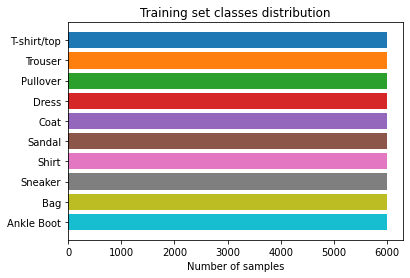

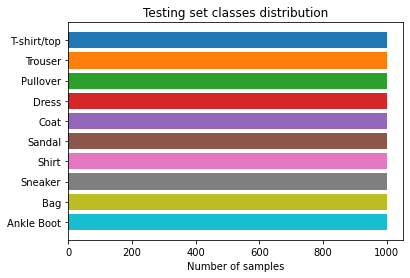

In [ ]:
def plot_classes_distribution(Y, labels, title="", colors=None):
  classes, counts = np.unique(Y, return_counts=True)
  samples_count = len(Y)

  f, ax = plt.subplots(1,1)

  sorted_class_labels = list(map(lambda x: labels[x], labels))
  ax.barh(classes, counts, color=colors if colors!=None else np.random.rand(len(classes),3))
  ax.set_yticks(classes, labels=sorted_class_labels)
  ax.invert_yaxis()

  ax.set_xlabel('Number of samples')
  ax.set_title(title)

  ax.plot()

plot_classes_distribution(y_train, class_labels, "Training set classes distribution", classes_colors)
plot_classes_distribution(y_test, class_labels, "Testing set classes distribution", classes_colors)

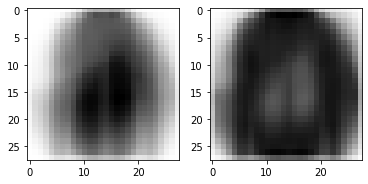

In [ ]:
def plot_samples_mean_and_variance(X):
  f, ax = plt.subplots(1, 2)

  average_corners = np.zeros(X[0].shape, dtype=X[0].dtype)

  sample_mean = np.mean(X, axis=0) 
  sample_std = np.std(X, axis=0)

  ax[0].imshow(sample_mean, cmap=plt.cm.binary)
  ax[1].imshow(sample_std, cmap=plt.cm.binary)
  
  plt.show()


plot_samples_mean_and_variance(x_train)

## Models

In [ ]:
def Baseline():
  model = keras.Sequential(
      [
      keras.Input(shape=input_shape),
      
      layers.Conv2D(6, kernel_size=(5, 5), activation="tanh", padding="same"),
      layers.AveragePooling2D(pool_size=(2, 2), padding="valid"),
       
      layers.Conv2D(16, kernel_size=(5, 5), activation="tanh", padding="valid"),
      layers.AveragePooling2D(pool_size=(2, 2), padding="valid"),
       
      layers.Conv2D(120, kernel_size=(5, 5), activation="tanh", padding="valid"),

      layers.Flatten(),
      layers.Dense(84, activation="tanh"),
      layers.Dense(classes_count, activation="softmax")
  ])    
  model._name = "Baseline"
  return model


def ReLu():
  model = keras.Sequential(
      [
      keras.Input(shape=input_shape),
      
      layers.Conv2D(6, kernel_size=(5, 5), activation="relu", padding="same"),
      layers.AveragePooling2D(pool_size=(2, 2), padding="valid"),
       
      layers.Conv2D(16, kernel_size=(5, 5), activation="relu", padding="valid"),
      layers.AveragePooling2D(pool_size=(2, 2), padding="valid"),
       
      layers.Conv2D(120, kernel_size=(5, 5), activation="relu", padding="valid"),

      layers.Flatten(),
      layers.Dense(84, activation="relu"),
      layers.Dense(classes_count, activation="softmax")
  ])    
  model._name = "ReLu"
  return model


def LeakyReLu():
  model = keras.Sequential(
      [
      keras.Input(shape=input_shape),
      
      layers.Conv2D(6, kernel_size=(5, 5), padding="same"),
      layers.LeakyReLU(),
      layers.AveragePooling2D(pool_size=(2, 2), padding="valid"),
       
      layers.Conv2D(16, kernel_size=(5, 5), padding="valid"),
      layers.LeakyReLU(),
      layers.AveragePooling2D(pool_size=(2, 2), padding="valid"),
       
      layers.Conv2D(120, kernel_size=(5, 5), padding="valid"),
      layers.LeakyReLU(),

      layers.Flatten(),
      layers.Dense(84),
      layers.LeakyReLU(),
      layers.Dense(classes_count, activation="softmax")
  ])    
  model._name = "LeakyReLu"
  return model


def MaxPooling():
  model = keras.Sequential(
      [
      keras.Input(shape=input_shape),
      
      layers.Conv2D(6, kernel_size=(5, 5), activation="tanh", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2), padding="valid"),
       
      layers.Conv2D(16, kernel_size=(5, 5), activation="tanh", padding="valid"),
      layers.MaxPooling2D(pool_size=(2, 2), padding="valid"),
       
      layers.Conv2D(120, kernel_size=(5, 5), activation="tanh", padding="valid"),

      layers.Flatten(),
      layers.Dense(84, activation="tanh"),
      layers.Dense(classes_count, activation="softmax")
  ])    
  model._name = "MaxPooling"
  return model


def L2Regularized():
  model = keras.Sequential(
      [
      keras.Input(shape=input_shape),
      
      layers.Conv2D(6, kernel_size=(5, 5), activation="tanh", padding="same", kernel_regularizer=regularizers.l2()),
      layers.AveragePooling2D(pool_size=(2, 2), padding="valid"),
       
      layers.Conv2D(16, kernel_size=(5, 5), activation="tanh", padding="valid", kernel_regularizer=regularizers.l2()),
      layers.AveragePooling2D(pool_size=(2, 2), padding="valid"),
       
      layers.Conv2D(120, kernel_size=(5, 5), activation="tanh", padding="valid", kernel_regularizer=regularizers.l2()),

      layers.Flatten(),
      layers.Dense(84, activation="tanh", kernel_regularizer=regularizers.l2()),
      layers.Dense(classes_count, activation="softmax")
  ])    
  model._name = "L2Regularized"
  return model

def BatchNorm():
  model = keras.Sequential(
      [
      keras.Input(shape=input_shape),
      
      layers.Conv2D(6, kernel_size=(5, 5), activation="tanh", padding="same"),
      layers.BatchNormalization(),
      layers.AveragePooling2D(pool_size=(2, 2), padding="valid"),
       
      layers.Conv2D(16, kernel_size=(5, 5), activation="tanh", padding="valid"),
      layers.BatchNormalization(),
      layers.AveragePooling2D(pool_size=(2, 2), padding="valid"),
       
      layers.Conv2D(120, kernel_size=(5, 5), activation="tanh", padding="valid"),
      layers.BatchNormalization(),

      layers.Flatten(),
      layers.BatchNormalization(),
      layers.Dense(84, activation="tanh"),
      layers.BatchNormalization(),
      layers.Dense(classes_count, activation="softmax")
  ])    
  model._name = "BatchNorm"
  return model

def Dropout():
  model = keras.Sequential(
      [
      keras.Input(shape=input_shape),
      
      layers.Conv2D(6, kernel_size=(5, 5), activation="tanh", padding="same"),
      layers.Dropout(0.25),
      layers.AveragePooling2D(pool_size=(2, 2), padding="valid"),
       
      layers.Conv2D(16, kernel_size=(5, 5), activation="tanh", padding="valid"),
      layers.Dropout(0.25),
      layers.AveragePooling2D(pool_size=(2, 2), padding="valid"),
       
      layers.Conv2D(120, kernel_size=(5, 5), activation="tanh", padding="valid"),
      layers.Dropout(0.25),

      layers.Flatten(),
      layers.Dropout(0.5),
      layers.Dense(84, activation="tanh"),
      layers.Dropout(0.5),
      layers.Dense(classes_count, activation="softmax")
  ])    
  model._name = "Dropout"
  return model


In [ ]:
model_builders = {
    "Baseline": Baseline,
    #"BaselineL2Regularized": L2Regularized,
    #"BaselineBatchNorm": BatchNorm,
    "Baseline+ReLu": ReLu,
    "Baseline+MaxPooling": MaxPooling,
    "Baseline+Dropout": Dropout,
    "Baseline+LeakyReLu": LeakyReLu
}

for model_build in model_builders.values():
  model = model_build()
  model.summary()
  visualkeras.layered_view(model, legend=True)

Model: "Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_459 (Conv2D)         (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_240 (Aver  (None, 14, 14, 6)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_460 (Conv2D)         (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_241 (Aver  (None, 5, 5, 16)         0         
 agePooling2D)                                                   
                                                                 
 conv2d_461 (Conv2D)         (None, 1, 1, 120)         48120     
                                                                 
 flatten_153 (Flatten)       (None, 120)               0  

## Training and Validation

In [ ]:
batch_size = 128
epochs = 15

In [ ]:
def learning_rate_step_le_net(step):
    if step <= 2: return 0.0005
    elif step <= 5: return 0.0002
    elif step <= 9: return 0.0005
    else: return 0.0001

def learning_rate_step_decay(step):
    initial_learning_rate = 0.01
    decay_factor = 0.5
    drop_every = 5

    learning_rate = initial_learning_rate * \
    (decay_factor ** ((1 + step) // drop_every))

    return learning_rate

In [ ]:
def train_model(model_builder, X, Y, validation_data=None, use_lr_decay=False, serialize_path=None, verbose=1, batch_size=batch_size, epochs=epochs):
  model = model_builder()
  learning_rate_scheduler = LearningRateScheduler(learning_rate_step_decay, verbose=verbose)
  
  if validation_data != None:
    validation_data = (validation_data[0], keras.utils.to_categorical(validation_data[1], classes_count))

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", Precision(name="precision"), Recall(name="recall")])
  history = model.fit(X, keras.utils.to_categorical(Y, classes_count),
                      callbacks=[learning_rate_scheduler] if use_lr_decay else [],
                      validation_data=validation_data,
                      batch_size=batch_size, epochs=epochs, verbose=verbose)
  
  if serialize_path is not None:
    model.save(serialize_path)

  return model, history

def stratified_k_fold_cross_validation(model_entry, X, Y, splits=10, batch_size=batch_size, epochs=epochs):
  skf = StratifiedKFold(n_splits=splits, shuffle=True)

  print(f"{splits}-Folds Stratified Cross-Validation started")

  histories = []

  for fold_index, (train_idxs, val_idxs) in enumerate(skf.split(X, Y)):
    x_train_fold, x_val_fold = X[train_idxs], X[val_idxs]
    y_train_fold, y_val_fold = Y[train_idxs], Y[val_idxs]

    print(f"Working with Fold {fold_index+1}")
    
    model_serial_path = os.path.join(os.getcwd(), "train/" + model_entry[0] + "/" + str(fold_index)) 

    _, history = train_model(model_entry[1], x_train_fold, y_train_fold, (x_val_fold, y_val_fold), False, model_serial_path)
    histories.append(history.history)

  return histories


In [ ]:
training_histories = dict()
cross_validation_splits = 5

for model_name, model_builder in model_builders.items():
  history = stratified_k_fold_cross_validation((model_name, model_builder), x_train, y_train, cross_validation_splits)
  training_histories[model_name] = history



5-Folds Stratified Cross-Validation started
Working with Fold 1
Epoch 1/15
375/375 [==============================] - 4s 7ms/step - loss: 0.6531 - accuracy: 0.7654 - precision: 0.8525 - recall: 0.6696 - val_loss: 0.4732 - val_accuracy: 0.8223 - val_precision: 0.8656 - val_recall: 0.7846
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.4353 - accuracy: 0.8424 - precision: 0.8775 - recall: 0.8076 - val_loss: 0.4167 - val_accuracy: 0.8497 - val_precision: 0.8822 - val_recall: 0.8192
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3838 - accuracy: 0.8610 - precision: 0.8901 - recall: 0.8354 - val_loss: 0.3767 - val_accuracy: 0.8637 - val_precision: 0.8898 - val_recall: 0.8377
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3530 - accuracy: 0.8730 - precision: 0.8972 - recall: 0.8501 - val_loss: 0.3615 - val_accuracy: 0.8678 - val_precision: 0.8909 - val_recall: 0.8468
Epoch 5/15
375/375 [====================

Working with Fold 2
Epoch 1/15
375/375 [==============================] - 4s 7ms/step - loss: 0.6514 - accuracy: 0.7618 - precision: 0.8531 - recall: 0.6709 - val_loss: 0.4821 - val_accuracy: 0.8238 - val_precision: 0.8713 - val_recall: 0.7700
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.4369 - accuracy: 0.8405 - precision: 0.8797 - recall: 0.8055 - val_loss: 0.4057 - val_accuracy: 0.8519 - val_precision: 0.8849 - val_recall: 0.8216
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3891 - accuracy: 0.8585 - precision: 0.8884 - recall: 0.8306 - val_loss: 0.3592 - val_accuracy: 0.8714 - val_precision: 0.8996 - val_recall: 0.8448
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3581 - accuracy: 0.8694 - precision: 0.8964 - recall: 0.8446 - val_loss: 0.3434 - val_accuracy: 0.8764 - val_precision: 0.8975 - val_recall: 0.8540
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3333 - a

Working with Fold 3
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.6603 - accuracy: 0.7570 - precision: 0.8539 - recall: 0.6671 - val_loss: 0.4868 - val_accuracy: 0.8251 - val_precision: 0.8722 - val_recall: 0.7791
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.4470 - accuracy: 0.8373 - precision: 0.8771 - recall: 0.7994 - val_loss: 0.4143 - val_accuracy: 0.8573 - val_precision: 0.8892 - val_recall: 0.8236
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3949 - accuracy: 0.8551 - precision: 0.8855 - recall: 0.8268 - val_loss: 0.3780 - val_accuracy: 0.8657 - val_precision: 0.8961 - val_recall: 0.8391
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3639 - accuracy: 0.8665 - precision: 0.8927 - recall: 0.8416 - val_loss: 0.3665 - val_accuracy: 0.8661 - val_precision: 0.8910 - val_recall: 0.8445
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3389 - a

Working with Fold 4
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.6440 - accuracy: 0.7647 - precision: 0.8555 - recall: 0.6737 - val_loss: 0.5158 - val_accuracy: 0.8052 - val_precision: 0.8420 - val_recall: 0.7642
Epoch 2/15
375/375 [==============================] - 3s 7ms/step - loss: 0.4373 - accuracy: 0.8429 - precision: 0.8791 - recall: 0.8063 - val_loss: 0.4137 - val_accuracy: 0.8510 - val_precision: 0.8888 - val_recall: 0.8167
Epoch 3/15
375/375 [==============================] - 3s 7ms/step - loss: 0.3866 - accuracy: 0.8591 - precision: 0.8887 - recall: 0.8314 - val_loss: 0.3681 - val_accuracy: 0.8667 - val_precision: 0.8968 - val_recall: 0.8432
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3571 - accuracy: 0.8706 - precision: 0.8961 - recall: 0.8465 - val_loss: 0.3659 - val_accuracy: 0.8698 - val_precision: 0.8965 - val_recall: 0.8435
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3333 - a

Working with Fold 5
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.6630 - accuracy: 0.7580 - precision: 0.8527 - recall: 0.6644 - val_loss: 0.4917 - val_accuracy: 0.8283 - val_precision: 0.8753 - val_recall: 0.7783
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.4499 - accuracy: 0.8363 - precision: 0.8764 - recall: 0.7974 - val_loss: 0.4213 - val_accuracy: 0.8464 - val_precision: 0.8811 - val_recall: 0.8109
Epoch 3/15
375/375 [==============================] - 2s 6ms/step - loss: 0.3922 - accuracy: 0.8591 - precision: 0.8892 - recall: 0.8299 - val_loss: 0.3861 - val_accuracy: 0.8573 - val_precision: 0.8839 - val_recall: 0.8330
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3648 - accuracy: 0.8674 - precision: 0.8942 - recall: 0.8414 - val_loss: 0.3608 - val_accuracy: 0.8654 - val_precision: 0.8928 - val_recall: 0.8424
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3399 - a

5-Folds Stratified Cross-Validation started
Working with Fold 1
Epoch 1/15
375/375 [==============================] - 5s 6ms/step - loss: 0.7615 - accuracy: 0.7194 - precision: 0.8373 - recall: 0.6041 - val_loss: 0.5152 - val_accuracy: 0.8092 - val_precision: 0.8724 - val_recall: 0.7354
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.5000 - accuracy: 0.8141 - precision: 0.8684 - recall: 0.7561 - val_loss: 0.4567 - val_accuracy: 0.8309 - val_precision: 0.8798 - val_recall: 0.7819
Epoch 3/15
375/375 [==============================] - 2s 6ms/step - loss: 0.4295 - accuracy: 0.8457 - precision: 0.8838 - recall: 0.8047 - val_loss: 0.3961 - val_accuracy: 0.8565 - val_precision: 0.8894 - val_recall: 0.8242
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3880 - accuracy: 0.8590 - precision: 0.8908 - recall: 0.8279 - val_loss: 0.3581 - val_accuracy: 0.8708 - val_precision: 0.8958 - val_recall: 0.8443
Epoch 5/15
375/375 [====================

Working with Fold 2
Epoch 1/15
375/375 [==============================] - 4s 7ms/step - loss: 0.7347 - accuracy: 0.7323 - precision: 0.8406 - recall: 0.6235 - val_loss: 0.5675 - val_accuracy: 0.7897 - val_precision: 0.8507 - val_recall: 0.7188
Epoch 2/15
375/375 [==============================] - 2s 6ms/step - loss: 0.4884 - accuracy: 0.8231 - precision: 0.8738 - recall: 0.7653 - val_loss: 0.4723 - val_accuracy: 0.8271 - val_precision: 0.8743 - val_recall: 0.7777
Epoch 3/15
375/375 [==============================] - 2s 6ms/step - loss: 0.4242 - accuracy: 0.8474 - precision: 0.8863 - recall: 0.8096 - val_loss: 0.4161 - val_accuracy: 0.8497 - val_precision: 0.8814 - val_recall: 0.8234
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3852 - accuracy: 0.8610 - precision: 0.8929 - recall: 0.8307 - val_loss: 0.3813 - val_accuracy: 0.8668 - val_precision: 0.8969 - val_recall: 0.8347
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3554 - a

Working with Fold 3
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.7227 - accuracy: 0.7353 - precision: 0.8422 - recall: 0.6328 - val_loss: 0.5135 - val_accuracy: 0.8151 - val_precision: 0.8758 - val_recall: 0.7413
Epoch 2/15
375/375 [==============================] - 2s 6ms/step - loss: 0.4889 - accuracy: 0.8209 - precision: 0.8702 - recall: 0.7652 - val_loss: 0.4515 - val_accuracy: 0.8367 - val_precision: 0.8846 - val_recall: 0.7803
Epoch 3/15
375/375 [==============================] - 2s 6ms/step - loss: 0.4270 - accuracy: 0.8455 - precision: 0.8834 - recall: 0.8043 - val_loss: 0.3948 - val_accuracy: 0.8569 - val_precision: 0.8896 - val_recall: 0.8260
Epoch 4/15
375/375 [==============================] - 2s 6ms/step - loss: 0.3842 - accuracy: 0.8619 - precision: 0.8917 - recall: 0.8311 - val_loss: 0.3690 - val_accuracy: 0.8669 - val_precision: 0.8956 - val_recall: 0.8428
Epoch 5/15
375/375 [==============================] - 2s 6ms/step - loss: 0.3550 - a

Working with Fold 4
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.7268 - accuracy: 0.7412 - precision: 0.8434 - recall: 0.6316 - val_loss: 0.5323 - val_accuracy: 0.8037 - val_precision: 0.8647 - val_recall: 0.7360
Epoch 2/15
375/375 [==============================] - 2s 6ms/step - loss: 0.4872 - accuracy: 0.8219 - precision: 0.8725 - recall: 0.7692 - val_loss: 0.4454 - val_accuracy: 0.8408 - val_precision: 0.8782 - val_recall: 0.7972
Epoch 3/15
375/375 [==============================] - 2s 6ms/step - loss: 0.4164 - accuracy: 0.8500 - precision: 0.8853 - recall: 0.8138 - val_loss: 0.4272 - val_accuracy: 0.8447 - val_precision: 0.8739 - val_recall: 0.8163
Epoch 4/15
375/375 [==============================] - 2s 6ms/step - loss: 0.3787 - accuracy: 0.8622 - precision: 0.8915 - recall: 0.8343 - val_loss: 0.3604 - val_accuracy: 0.8691 - val_precision: 0.8968 - val_recall: 0.8447
Epoch 5/15
375/375 [==============================] - 2s 6ms/step - loss: 0.3497 - a

Working with Fold 5
Epoch 1/15
375/375 [==============================] - 5s 7ms/step - loss: 0.7271 - accuracy: 0.7305 - precision: 0.8445 - recall: 0.6239 - val_loss: 0.5357 - val_accuracy: 0.7997 - val_precision: 0.8583 - val_recall: 0.7394
Epoch 2/15
375/375 [==============================] - 2s 6ms/step - loss: 0.4844 - accuracy: 0.8222 - precision: 0.8711 - recall: 0.7687 - val_loss: 0.4797 - val_accuracy: 0.8244 - val_precision: 0.8792 - val_recall: 0.7672
Epoch 3/15
375/375 [==============================] - 2s 6ms/step - loss: 0.4248 - accuracy: 0.8454 - precision: 0.8836 - recall: 0.8077 - val_loss: 0.4435 - val_accuracy: 0.8378 - val_precision: 0.8787 - val_recall: 0.7992
Epoch 4/15
375/375 [==============================] - 2s 6ms/step - loss: 0.3899 - accuracy: 0.8586 - precision: 0.8913 - recall: 0.8292 - val_loss: 0.4195 - val_accuracy: 0.8441 - val_precision: 0.8751 - val_recall: 0.8177
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3613 - a

5-Folds Stratified Cross-Validation started
Working with Fold 1
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.5987 - accuracy: 0.7840 - precision: 0.8705 - recall: 0.6983 - val_loss: 0.4007 - val_accuracy: 0.8612 - val_precision: 0.8917 - val_recall: 0.8265
Epoch 2/15
375/375 [==============================] - 2s 6ms/step - loss: 0.3768 - accuracy: 0.8623 - precision: 0.8902 - recall: 0.8374 - val_loss: 0.3402 - val_accuracy: 0.8804 - val_precision: 0.9015 - val_recall: 0.8573
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3265 - accuracy: 0.8802 - precision: 0.9023 - recall: 0.8590 - val_loss: 0.3335 - val_accuracy: 0.8771 - val_precision: 0.8999 - val_recall: 0.8558
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3006 - accuracy: 0.8903 - precision: 0.9096 - recall: 0.8734 - val_loss: 0.2998 - val_accuracy: 0.8907 - val_precision: 0.9097 - val_recall: 0.8736
Epoch 5/15
375/375 [====================

Working with Fold 2
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.5915 - accuracy: 0.7871 - precision: 0.8689 - recall: 0.7024 - val_loss: 0.4181 - val_accuracy: 0.8478 - val_precision: 0.8851 - val_recall: 0.8152
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3828 - accuracy: 0.8602 - precision: 0.8890 - recall: 0.8330 - val_loss: 0.3524 - val_accuracy: 0.8767 - val_precision: 0.8990 - val_recall: 0.8543
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3371 - accuracy: 0.8772 - precision: 0.8998 - recall: 0.8568 - val_loss: 0.3301 - val_accuracy: 0.8822 - val_precision: 0.9022 - val_recall: 0.8637
Epoch 4/15
375/375 [==============================] - 2s 6ms/step - loss: 0.3055 - accuracy: 0.8872 - precision: 0.9070 - recall: 0.8698 - val_loss: 0.3068 - val_accuracy: 0.8916 - val_precision: 0.9090 - val_recall: 0.8773
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 0.2868 - a

Working with Fold 3
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.5896 - accuracy: 0.7890 - precision: 0.8698 - recall: 0.7071 - val_loss: 0.4109 - val_accuracy: 0.8510 - val_precision: 0.8884 - val_recall: 0.8136
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3829 - accuracy: 0.8608 - precision: 0.8898 - recall: 0.8355 - val_loss: 0.3785 - val_accuracy: 0.8615 - val_precision: 0.8854 - val_recall: 0.8379
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3360 - accuracy: 0.8785 - precision: 0.9003 - recall: 0.8590 - val_loss: 0.3148 - val_accuracy: 0.8819 - val_precision: 0.9047 - val_recall: 0.8643
Epoch 4/15
375/375 [==============================] - 2s 6ms/step - loss: 0.3101 - accuracy: 0.8874 - precision: 0.9060 - recall: 0.8703 - val_loss: 0.2961 - val_accuracy: 0.8903 - val_precision: 0.9099 - val_recall: 0.8742
Epoch 5/15
375/375 [==============================] - 2s 6ms/step - loss: 0.2852 - a

Working with Fold 4
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.5836 - accuracy: 0.7898 - precision: 0.8705 - recall: 0.7090 - val_loss: 0.4257 - val_accuracy: 0.8504 - val_precision: 0.8867 - val_recall: 0.8157
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3843 - accuracy: 0.8621 - precision: 0.8895 - recall: 0.8345 - val_loss: 0.3743 - val_accuracy: 0.8652 - val_precision: 0.8919 - val_recall: 0.8425
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3345 - accuracy: 0.8794 - precision: 0.9014 - recall: 0.8574 - val_loss: 0.3434 - val_accuracy: 0.8762 - val_precision: 0.9001 - val_recall: 0.8597
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3065 - accuracy: 0.8883 - precision: 0.9072 - recall: 0.8705 - val_loss: 0.3232 - val_accuracy: 0.8834 - val_precision: 0.9063 - val_recall: 0.8644
Epoch 5/15
375/375 [==============================] - 2s 6ms/step - loss: 0.2853 - a

Working with Fold 5
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.6017 - accuracy: 0.7827 - precision: 0.8656 - recall: 0.6980 - val_loss: 0.4697 - val_accuracy: 0.8269 - val_precision: 0.8671 - val_recall: 0.7937
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3890 - accuracy: 0.8588 - precision: 0.8894 - recall: 0.8319 - val_loss: 0.3763 - val_accuracy: 0.8611 - val_precision: 0.8849 - val_recall: 0.8396
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3412 - accuracy: 0.8768 - precision: 0.8994 - recall: 0.8559 - val_loss: 0.3536 - val_accuracy: 0.8706 - val_precision: 0.8907 - val_recall: 0.8491
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3106 - accuracy: 0.8878 - precision: 0.9080 - recall: 0.8699 - val_loss: 0.3227 - val_accuracy: 0.8837 - val_precision: 0.9021 - val_recall: 0.8668
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 0.2879 - a

5-Folds Stratified Cross-Validation started
Working with Fold 1
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.8885 - accuracy: 0.6746 - precision: 0.7911 - recall: 0.5644 - val_loss: 0.5440 - val_accuracy: 0.8023 - val_precision: 0.8606 - val_recall: 0.7423
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.6580 - accuracy: 0.7644 - precision: 0.8270 - recall: 0.7003 - val_loss: 0.5010 - val_accuracy: 0.8253 - val_precision: 0.8642 - val_recall: 0.7824
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 0.6137 - accuracy: 0.7843 - precision: 0.8375 - recall: 0.7274 - val_loss: 0.4722 - val_accuracy: 0.8316 - val_precision: 0.8701 - val_recall: 0.7958
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.5840 - accuracy: 0.7947 - precision: 0.8425 - recall: 0.7454 - val_loss: 0.4599 - val_accuracy: 0.8378 - val_precision: 0.8690 - val_recall: 0.8071
Epoch 5/15
375/375 [====================

Working with Fold 2
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.8904 - accuracy: 0.6690 - precision: 0.7857 - recall: 0.5557 - val_loss: 0.5567 - val_accuracy: 0.7937 - val_precision: 0.8485 - val_recall: 0.7399
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.6524 - accuracy: 0.7650 - precision: 0.8266 - recall: 0.7006 - val_loss: 0.5082 - val_accuracy: 0.8170 - val_precision: 0.8585 - val_recall: 0.7709
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 0.6036 - accuracy: 0.7851 - precision: 0.8380 - recall: 0.7316 - val_loss: 0.4760 - val_accuracy: 0.8283 - val_precision: 0.8647 - val_recall: 0.7937
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.5795 - accuracy: 0.7930 - precision: 0.8431 - recall: 0.7438 - val_loss: 0.4581 - val_accuracy: 0.8369 - val_precision: 0.8658 - val_recall: 0.8057
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 0.5551 - a

Working with Fold 3
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.9180 - accuracy: 0.6629 - precision: 0.7871 - recall: 0.5437 - val_loss: 0.5599 - val_accuracy: 0.7985 - val_precision: 0.8539 - val_recall: 0.7259
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.6667 - accuracy: 0.7607 - precision: 0.8238 - recall: 0.6932 - val_loss: 0.5086 - val_accuracy: 0.8148 - val_precision: 0.8632 - val_recall: 0.7592
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 0.6188 - accuracy: 0.7782 - precision: 0.8345 - recall: 0.7200 - val_loss: 0.4859 - val_accuracy: 0.8239 - val_precision: 0.8655 - val_recall: 0.7787
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.5917 - accuracy: 0.7890 - precision: 0.8394 - recall: 0.7370 - val_loss: 0.4734 - val_accuracy: 0.8298 - val_precision: 0.8713 - val_recall: 0.7928
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 0.5732 - a

Working with Fold 4
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.9033 - accuracy: 0.6670 - precision: 0.7877 - recall: 0.5540 - val_loss: 0.5874 - val_accuracy: 0.7840 - val_precision: 0.8341 - val_recall: 0.7228
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.6633 - accuracy: 0.7618 - precision: 0.8265 - recall: 0.6955 - val_loss: 0.5400 - val_accuracy: 0.8017 - val_precision: 0.8463 - val_recall: 0.7543
Epoch 3/15
375/375 [==============================] - 2s 6ms/step - loss: 0.6137 - accuracy: 0.7808 - precision: 0.8358 - recall: 0.7239 - val_loss: 0.5175 - val_accuracy: 0.8132 - val_precision: 0.8525 - val_recall: 0.7782
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.5897 - accuracy: 0.7905 - precision: 0.8416 - recall: 0.7380 - val_loss: 0.4845 - val_accuracy: 0.8265 - val_precision: 0.8605 - val_recall: 0.7976
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 0.5714 - a

Working with Fold 5
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.9110 - accuracy: 0.6668 - precision: 0.7834 - recall: 0.5446 - val_loss: 0.5703 - val_accuracy: 0.7876 - val_precision: 0.8440 - val_recall: 0.7322
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.6699 - accuracy: 0.7573 - precision: 0.8239 - recall: 0.6877 - val_loss: 0.5131 - val_accuracy: 0.8129 - val_precision: 0.8571 - val_recall: 0.7683
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 0.6234 - accuracy: 0.7799 - precision: 0.8370 - recall: 0.7213 - val_loss: 0.4939 - val_accuracy: 0.8204 - val_precision: 0.8544 - val_recall: 0.7825
Epoch 4/15
375/375 [==============================] - 2s 6ms/step - loss: 0.5932 - accuracy: 0.7875 - precision: 0.8390 - recall: 0.7348 - val_loss: 0.4735 - val_accuracy: 0.8273 - val_precision: 0.8585 - val_recall: 0.7942
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 0.5722 - a

5-Folds Stratified Cross-Validation started
Working with Fold 1
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.7129 - accuracy: 0.7380 - precision: 0.8416 - recall: 0.6420 - val_loss: 0.4876 - val_accuracy: 0.8228 - val_precision: 0.8866 - val_recall: 0.7458
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.4714 - accuracy: 0.8290 - precision: 0.8751 - recall: 0.7822 - val_loss: 0.4185 - val_accuracy: 0.8454 - val_precision: 0.8888 - val_recall: 0.8028
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 0.4141 - accuracy: 0.8483 - precision: 0.8831 - recall: 0.8160 - val_loss: 0.3746 - val_accuracy: 0.8617 - val_precision: 0.8917 - val_recall: 0.8320
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3762 - accuracy: 0.8632 - precision: 0.8919 - recall: 0.8363 - val_loss: 0.3940 - val_accuracy: 0.8553 - val_precision: 0.8843 - val_recall: 0.8296
Epoch 5/15
375/375 [====================

Working with Fold 2
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.7520 - accuracy: 0.7267 - precision: 0.8309 - recall: 0.6165 - val_loss: 0.5518 - val_accuracy: 0.8023 - val_precision: 0.8614 - val_recall: 0.7352
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.4912 - accuracy: 0.8200 - precision: 0.8695 - recall: 0.7678 - val_loss: 0.4763 - val_accuracy: 0.8287 - val_precision: 0.8705 - val_recall: 0.7878
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 0.4200 - accuracy: 0.8492 - precision: 0.8843 - recall: 0.8144 - val_loss: 0.4482 - val_accuracy: 0.8357 - val_precision: 0.8682 - val_recall: 0.8039
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3850 - accuracy: 0.8587 - precision: 0.8889 - recall: 0.8306 - val_loss: 0.3936 - val_accuracy: 0.8601 - val_precision: 0.8860 - val_recall: 0.8328
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3590 - a

Working with Fold 3
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.7381 - accuracy: 0.7306 - precision: 0.8337 - recall: 0.6305 - val_loss: 0.5771 - val_accuracy: 0.7893 - val_precision: 0.8462 - val_recall: 0.7403
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.5065 - accuracy: 0.8171 - precision: 0.8674 - recall: 0.7606 - val_loss: 0.4669 - val_accuracy: 0.8350 - val_precision: 0.8851 - val_recall: 0.7768
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 0.4445 - accuracy: 0.8416 - precision: 0.8793 - recall: 0.8025 - val_loss: 0.4038 - val_accuracy: 0.8563 - val_precision: 0.8869 - val_recall: 0.8244
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.4062 - accuracy: 0.8537 - precision: 0.8860 - recall: 0.8225 - val_loss: 0.3808 - val_accuracy: 0.8624 - val_precision: 0.8895 - val_recall: 0.8394
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3824 - a

Working with Fold 4
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.6862 - accuracy: 0.7510 - precision: 0.8480 - recall: 0.6571 - val_loss: 0.5145 - val_accuracy: 0.8208 - val_precision: 0.8725 - val_recall: 0.7553
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.4598 - accuracy: 0.8342 - precision: 0.8757 - recall: 0.7915 - val_loss: 0.4282 - val_accuracy: 0.8454 - val_precision: 0.8819 - val_recall: 0.8059
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 0.4052 - accuracy: 0.8533 - precision: 0.8856 - recall: 0.8220 - val_loss: 0.3947 - val_accuracy: 0.8594 - val_precision: 0.8855 - val_recall: 0.8322
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3729 - accuracy: 0.8637 - precision: 0.8912 - recall: 0.8385 - val_loss: 0.3716 - val_accuracy: 0.8685 - val_precision: 0.8981 - val_recall: 0.8398
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3477 - a

Working with Fold 5
Epoch 1/15
375/375 [==============================] - 4s 6ms/step - loss: 0.7125 - accuracy: 0.7438 - precision: 0.8445 - recall: 0.6390 - val_loss: 0.5171 - val_accuracy: 0.8049 - val_precision: 0.8633 - val_recall: 0.7470
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.4791 - accuracy: 0.8251 - precision: 0.8709 - recall: 0.7738 - val_loss: 0.4544 - val_accuracy: 0.8367 - val_precision: 0.8784 - val_recall: 0.7898
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 0.4121 - accuracy: 0.8510 - precision: 0.8850 - recall: 0.8173 - val_loss: 0.4408 - val_accuracy: 0.8353 - val_precision: 0.8677 - val_recall: 0.8109
Epoch 4/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3807 - accuracy: 0.8620 - precision: 0.8904 - recall: 0.8350 - val_loss: 0.3791 - val_accuracy: 0.8664 - val_precision: 0.8918 - val_recall: 0.8420
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 0.3536 - a

## Models comparison and selection

In [ ]:
def print_highest_metrics(histories, key="val_accuracy", epochs=epochs, cv_folds=cross_validation_splits):
  print("Maximum", key, "in", epochs, "Epochs and", cv_folds, "cv folds")
  for model_name in histories.keys():
    mx = -1
    ep = 0
    for i in range(cv_folds):
      cm = np.max(histories[model_name][i][key])
      if cm > mx:
        mx = cm
        ep = i
        
    print(model_name, "model", mx, "@epoch", ep)
    

def get_aggregate_train_and_validation_losses(histories, key="loss"):
  train_loss_aggregate = np.zeros(epochs, dtype=np.float32)
  validation_loss_aggregate = np.zeros(epochs, dtype=np.float32)

  for i in range(len(histories)):
      train_loss_aggregate += np.array(histories[i][key])
      validation_loss_aggregate += np.array(histories[i]["val_" + key])

  train_loss_aggregate /= len(histories)
  validation_loss_aggregate /= len(histories)

  return train_loss_aggregate, validation_loss_aggregate


def plot_training_histories(histories, key="loss"):

  figure, axis = plt.subplots(1, len(histories))

  for plot_idx, model_name in enumerate(histories.keys()):
    tl, vl = get_aggregate_train_and_validation_losses(histories[model_name], key)
    ax = axis[plot_idx] if len(histories) > 1 else axis
    
    ax.plot(tl)
    ax.plot(vl)
    ax.set_title(model_name)
    ax.set_ylabel(key.capitalize())
    ax.set_xlabel('epoch')
    ax.legend(['train', 'val'], loc='upper left')
      

  figure.set_figwidth(15)
  figure.tight_layout()
  plt.show()


def print_metric_values(metrics):
  for model_name, values in metrics:
    print(model_name, "model")
    for metric in values.keys():
      print(metric, ":", values[metric])
    print("---")

def process_histories(histories):
  metric_values = []
  for model_name in histories.keys():
    pair = [model_name, dict()]
    for metric in histories[model_name][0].keys():
      pair[1][metric] = histories[model_name][-1][metric][-1]
    metric_values.append(pair)

  return metric_values

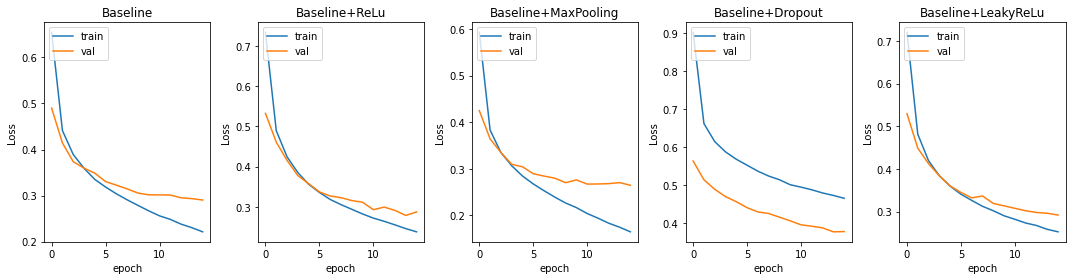

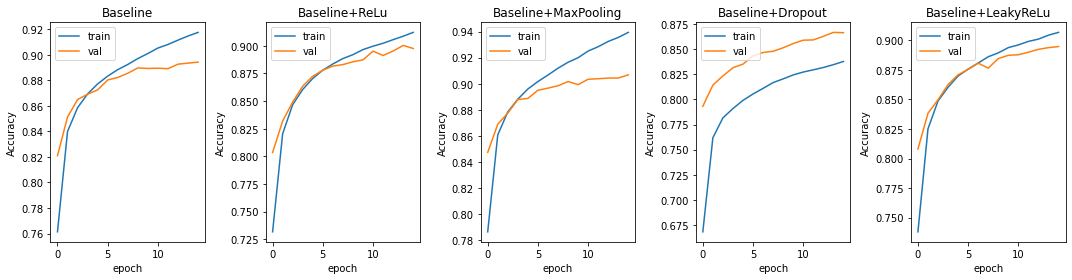

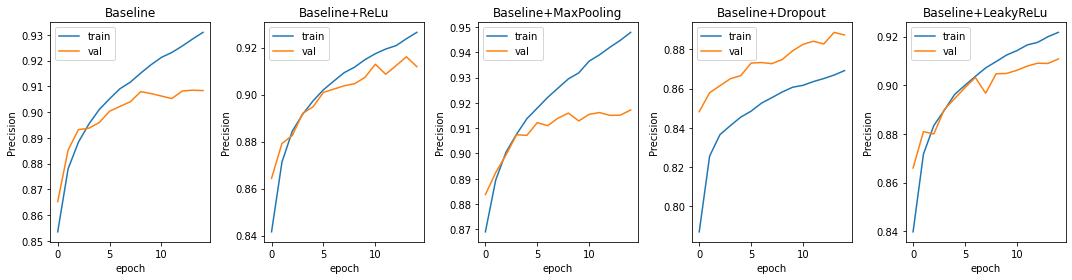

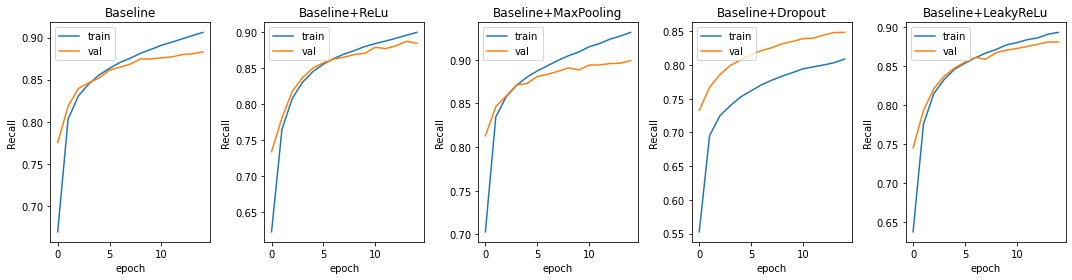

In [ ]:
plot_training_histories(training_histories)
plot_training_histories(training_histories, "accuracy")
plot_training_histories(training_histories, "precision")
plot_training_histories(training_histories, "recall")

print("")
metrics = process_histories(training_histories)
metrics = list(sorted(metrics, key=lambda x: x[1]["val_accuracy"], reverse=True))

## Best models evaluation on test set

In [ ]:
best_models = [("Baseline+ReLu", ReLu), ("Baseline+ReLuLeaky", ReLuLeaky)]
metrics = []
sorted_classes=list(map(lambda x: x[1], sorted(class_labels.items(), key=lambda x: x[0])))

for model_name, model_builder in best_models:
  model_serial_path = os.path.join(os.getcwd(), "test/" + model_name)
  model, _ = train_model(model_builder, x_train, y_train, None, False, model_serial_path, 0)
  score = model.evaluate(x_test, keras.utils.to_categorical(y_test, classes_count), verbose=0)
  
  metrics.append([model_name, {key:value for key,value in zip(model.metrics_names, score)}])

print_metric_values(metrics)

Baseline+ReLu model
loss : 0.2836138606071472
accuracy : 0.8974999785423279
precision : 0.9089978337287903
recall : 0.8880000114440918
---
Baseline+ReLuLeaky model
loss : 0.30089738965034485
accuracy : 0.890999972820282
precision : 0.9083462953567505
recall : 0.8761000037193298
---


## Choice Tasks
#### CHOICE 2: Create and apply a function to decrease the learning rate at a 1/2 of the value every 5 epochs

Baseline+ReLu model
loss : 0.30286070704460144
accuracy : 0.9085000157356262
precision : 0.9167259931564331
recall : 0.9016000032424927
---
Baseline+ReLuLeaky model
loss : 0.286957323551178
accuracy : 0.910099983215332
precision : 0.9184004664421082
recall : 0.9049000144004822
---


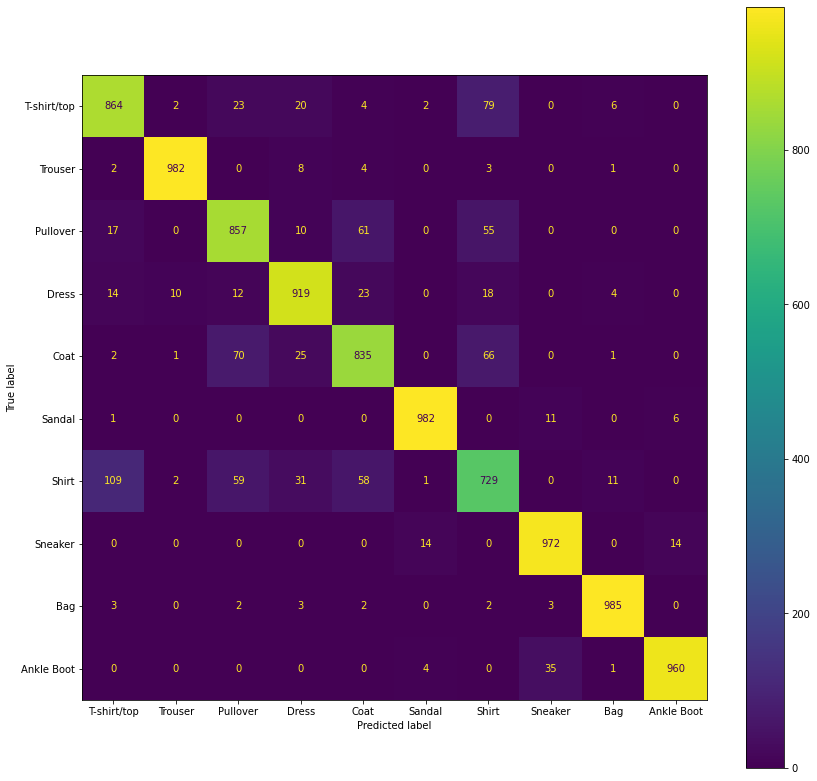

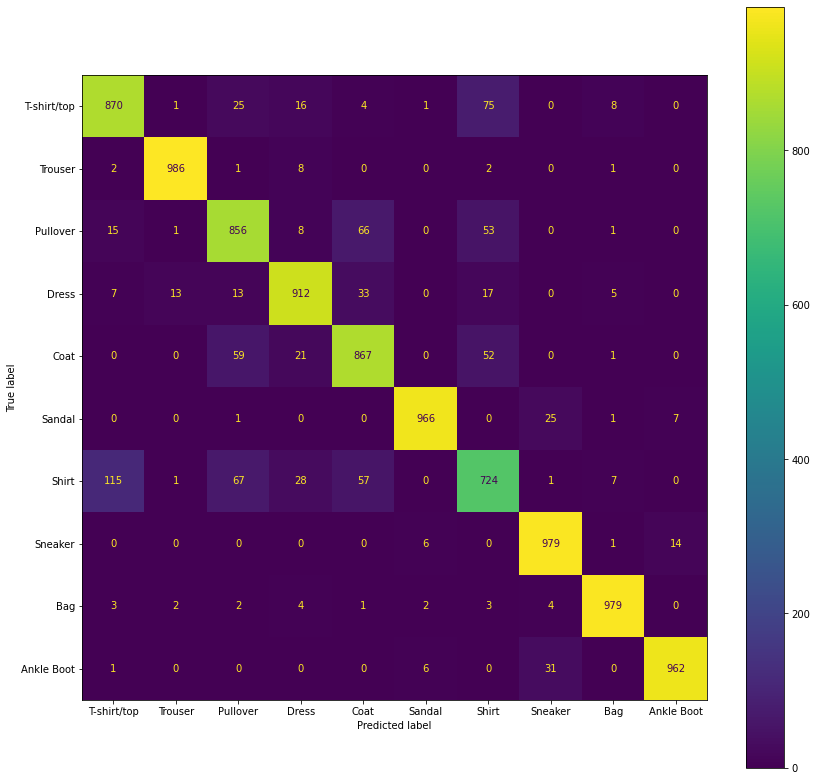

In [ ]:
metrics = []

for model_name, model_builder in best_models:
  model_serial_path = os.path.join(os.getcwd(), "test/" + model_name + "_lr_decay")
  model, _ = train_model(model_builder, x_train, y_train, None, True, model_serial_path, 0)
  score = model.evaluate(x_test, keras.utils.to_categorical(y_test, classes_count), verbose=0)
  
  metrics.append([model_name, {key:value for key,value in zip(model.metrics_names, score)}])

  y_pred = model.predict(x_test, verbose=0)
  y_pred_labels = np.argmax(y_pred, axis=1)

  conf_matrix = confusion_matrix(y_test, y_pred_labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=sorted_classes)
  fig, ax = plt.subplots(figsize=(14,14))
  disp.plot(ax=ax)


print_metric_values(metrics)

#### CHOICE 1: Provide and explain a confusion matrix for the results on the test set of one of the models

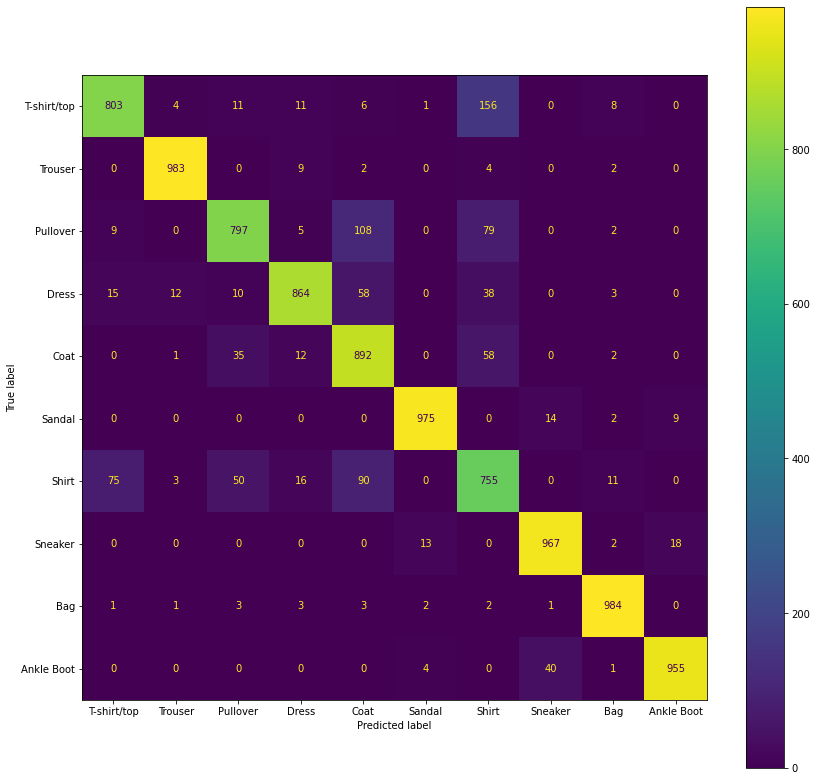

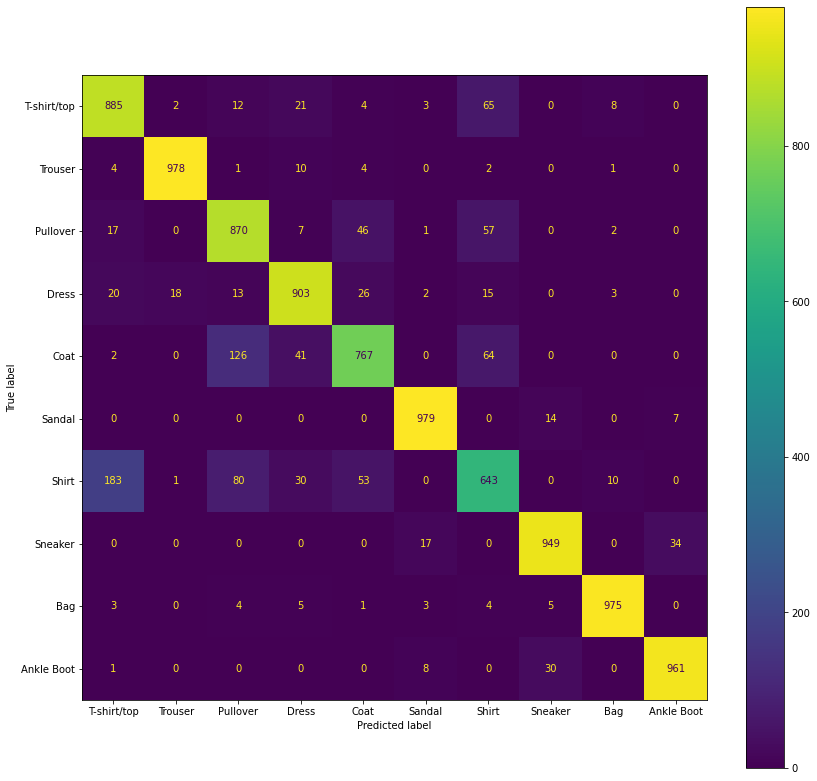

In [ ]:
sorted_classes=list(map(lambda x: x[1], sorted(class_labels.items(), key=lambda x: x[0])))

for model_name, _ in best_models:
  model_serial_path = os.path.join(os.getcwd(), "test/" + model_name)
  model = load_model(model_serial_path)

  score = model.evaluate(x_test, keras.utils.to_categorical(y_test, classes_count), verbose=0)
  
  y_pred = model.predict(x_test, verbose=0)
  y_pred_labels = np.argmax(y_pred, axis=1)

  conf_matrix = confusion_matrix(y_test, y_pred_labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=sorted_classes)
  fig, ax = plt.subplots(figsize=(14,14))
  disp.plot(ax=ax)

In [ ]:
!zip -r /content/test.zip /content/test
!zip -r /content/train.zip /content/train

files.download("/content/test.zip")
files.download("/content/train.zip")

updating: content/test/ (stored 0%)
updating: content/test/Baseline+MaxPooling_lr_decay/ (stored 0%)
updating: content/test/Baseline+MaxPooling_lr_decay/assets/ (stored 0%)
updating: content/test/Baseline+MaxPooling_lr_decay/variables/ (stored 0%)
updating: content/test/Baseline+MaxPooling_lr_decay/variables/variables.index (deflated 64%)
updating: content/test/Baseline+MaxPooling_lr_decay/variables/variables.data-00000-of-00001 (deflated 9%)
updating: content/test/Baseline+MaxPooling_lr_decay/keras_metadata.pb (deflated 91%)
updating: content/test/Baseline+MaxPooling_lr_decay/saved_model.pb (deflated 88%)
updating: content/test/Baseline+MaxPooling_lr_decay/fingerprint.pb (stored 0%)
updating: content/test/Baseline+ReLu_lr_decay/ (stored 0%)
updating: content/test/Baseline+ReLu_lr_decay/assets/ (stored 0%)
updating: content/test/Baseline+ReLu_lr_decay/variables/ (stored 0%)
updating: content/test/Baseline+ReLu_lr_decay/variables/variables.index (deflated 64%)
updating: content/test/Bas

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>